In [ ]:
!pip install underthesea --quiet
!pip install sklearn_crfsuite --quiet

In [ ]:
import nltk
import numpy as np
import pandas as pd
import underthesea
import re
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn_crfsuite import CRF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

In [ ]:
def read_file(file_name):
    return open(file_name, 'r', encoding='utf-8').read().split('\n')

def write_file(file_name, text):
    file = open(file_name, 'w', encoding='utf-8')
    for sentences in text:
        file.writelines(sentences + '\n')

In [ ]:
def inspect_tag(tag) -> bool:
    pattern = re.compile(r'^[A-Z][a-z]?$')
    return bool(pattern.search(tag))

In [ ]:
def inspect_word(word) -> bool:
    pattern = re.compile(r'[!"#$%&\'()*+,-./:;<=>?@\[\]^`{|}~“”\\]+')
    return not(bool(pattern.search(word)))

In [ ]:
def get_raw_text(filename):
    """
    - trả về data nguyên bản (kể cả các invalid word, tag) trong file
    - bên cạnh đó, xử lí word và tag -> tách tag và word sau đó kẹp thành 1 tuple như này (word, tag)
    - loại bỏ các word không tag hoặc word có nhiều hơn 1 tag
    """ 
    text = read_file(filename)
    data = []

    for sentence in text:
        for duo in sentence.strip().split(' '):
            data.append(tuple(duo.split('/')))

    data = [duo for duo in data if len(duo) == 2]
    return data

In [ ]:
def get_processed_data(filename):
    opening = ('<s>', '<s>')
    ending = ('</s>', '</s>')

    corpus = get_raw_text(filename)
    refreshed_data = []
    sentence = []

    for word, tag in corpus:
        if inspect_word(word) and inspect_tag(tag):
            sentence.append((word, tag))
        elif word in ['.', '...', ':', '!', '?', '-', '"']:
            
            refreshed_data.append([opening] + sentence + [ending])
            sentence.clear()

    return refreshed_data

In [ ]:
def load_corpus(filename):
    data = get_processed_data(filename)
    corpus = []
    for sentence in data:
        corpus.extend(sentence)
    return corpus

In [ ]:
path = "/content/drive/MyDrive/[postgrad] S1Y3/NLP/dataset/BTL/data.pos"
corpus = load_corpus(path)

In [ ]:
corpus[:5]

[('<s>', '<s>'),
 ('Hải_tặc', 'N'),
 ('eo_biển', 'N'),
 ('Malacca', 'Np'),
 ('kỳ', 'N')]

## train test split 

In [ ]:
train_set, test_set = train_test_split(corpus, test_size=0.2, random_state=27)

In [ ]:
print("trainset size",len(train_set))
print("testset size",len(test_set))

trainset size 172512
testset size 43129


## dictionary parameters 

In [ ]:
emission_count = Counter(train_set)
all_tags = [tag for _,tag in train_set]
all_words = [word for word,_ in train_set]
tag_count = Counter(all_tags)
transition_count = Counter(nltk.bigrams(all_tags))

In [ ]:
len(all_words)

172512

In [ ]:
tags = set(all_tags)
vocab = set(all_words)

print(f"there're {len(tags)} tags, including opening and closing tags")
print(f"they're {sorted(tags)}")

there're 29 tags, including opening and closing tags
they're ['</s>', '<s>', 'A', 'Ab', 'Ap', 'B', 'C', 'E', 'Eb', 'H', 'I', 'L', 'M', 'Mb', 'N', 'Nb', 'Nc', 'Np', 'Nu', 'Ny', 'P', 'R', 'S', 'T', 'V', 'Vb', 'Vy', 'X', 'Y']


# Hidden Markov Model with Viterbi algorithm

In [ ]:
def P_t2_given_t1(t2, t1): # kết hợp Laplace smoothing
    alpha = 0.001
    return (transition_count[(t2, t1)]+ alpha)/ (tag_count[t1]+ alpha * len(tags))

In [ ]:
def P_w_given_t(word, tag):
    return (emission_count[(word, tag)])/(tag_count[tag])

In [ ]:
transition_probability = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(tags):
    for j, t2 in enumerate(tags):
        transition_probability[i, j] = P_t2_given_t1(t2, t1)

In [ ]:
# transition_table
transition_table = pd.DataFrame(transition_probability, columns = tags, index=tags)

In [ ]:
transition_table

,Nc,P,T,N,X,H,E,R,</s>,Ny,...,Ap,<s>,Np,A,C,S,Nb,Vb,M,I
Nc,0.026262,0.039846,0.005660,0.247904,0.002717,2.263965e-07,0.064297,0.074258,0.070410,0.004981,...,2.266229e-04,0.067466,0.038035,0.059316,0.034412,4.530194e-04,0.001359,2.266229e-04,0.040978,6.794159e-04
P,0.026312,0.039601,0.006778,0.246644,0.003987,1.328899e-07,0.056478,0.075349,0.069103,0.004784,...,1.328899e-07,0.061528,0.040399,0.064850,0.033621,9.303619e-04,0.001329,2.659126e-04,0.038538,1.328899e-07
T,0.029851,0.041264,0.008780,0.232655,0.002635,8.779407e-07,0.064968,0.068480,0.060579,0.008780,...,8.779407e-07,0.062335,0.035996,0.079893,0.037752,8.779407e-07,0.001757,8.779407e-07,0.050921,8.788187e-04
N,0.025431,0.043716,0.006764,0.241622,0.003442,2.390170e-08,0.063124,0.075027,0.066447,0.005474,...,2.390170e-08,0.065491,0.039055,0.062527,0.037908,8.126817e-04,0.001673,7.172900e-05,0.036331,6.453698e-04
X,0.029052,0.055045,0.004588,0.252284,0.004588,1.528984e-06,0.061161,0.061161,0.077980,0.006117,...,1.528984e-06,0.067277,0.036697,0.051987,0.027523,1.528984e-06,0.003059,1.528984e-06,0.038226,1.528984e-06
H,0.000972,0.000972,0.000972,0.972789,0.000972,9.718173e-04,0.000972,0.000972,0.000972,0.000972,...,9.718173e-04,0.000972,0.000972,0.000972,0.000972,9.718173e-04,0.000972,9.718173e-04,0.000972,9.718173e-04
E,0.027276,0.043331,0.007389,0.246943,0.003831,9.122399e-08,0.063948,0.076081,0.063492,0.004835,...,9.122399e-08,0.064495,0.039956,0.066411,0.033753,7.298831e-04,0.001916,1.825392e-04,0.036398,3.649872e-04
R,0.024194,0.045110,0.007258,0.243112,0.003980,7.804556e-08,0.063607,0.074924,0.066573,0.005619,...,7.804556e-08,0.062983,0.043237,0.064154,0.036681,7.812360e-05,0.001717,7.804556e-08,0.034106,3.122603e-04
</s>,0.027424,0.043967,0.006812,0.232395,0.003981,8.846403e-08,0.064402,0.073337,0.068648,0.004246,...,8.846403e-08,0.063429,0.040959,0.065640,0.037243,7.962648e-04,0.001681,8.846403e-08,0.033793,3.539446e-04
Ny,0.024619,0.055099,0.007035,0.233287,0.010552,1.172293e-06,0.056271,0.077373,0.056271,0.001173,...,1.172293e-06,0.063305,0.045721,0.090268,0.035170,1.173465e-03,0.003518,1.172293e-06,0.030481,1.172293e-06


## HMM + viterbi

In [ ]:
def viterbi(tokens):
    pred = []
    T = list(tags)
    for idx in range(len(tokens)):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if idx == 0:
                transition_p = transition_table.loc['<s>', tag]
            else:
                transition_p = transition_table.loc[pred[-1], tag]
            # compute emission and state probabilities
            emission_p = P_w_given_t(tokens[idx], tag)
            state_probability = emission_p * transition_p
            p.append(state_probability)

        argmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(argmax)]
        pred.append(state_max)
    return pred

In [ ]:
test_word = [duo[0] for duo in test_set]
test_tag= [duo[1] for duo in test_set]

In [ ]:
predict_tags = viterbi(test_word)

0.8821906373901551

In [ ]:
print(accuracy_score(test_tag, predict_tags))
print(f1_score(test_tag, predict_tags, average="weighted"))

0.8821906373901551
0.8881192208046113


predict tag

In [ ]:
def predict_tag(sent):
    tokens = underthesea.word_tokenize(sent, format="text")
    tokens = tokens.split()
    return list(zip(tokens,viterbi(tokens)))

In [ ]:
s1 = 'Tôi thích học xử lí ngôn ngữ tự nhiên'
predict_tag(s1)

[('Tôi', 'P'),
 ('thích', 'V'),
 ('học', 'V'),
 ('xử_lí', 'Nc'),
 ('ngôn_ngữ', 'N'),
 ('tự_nhiên', 'A')]

# HMM by nltk library

In [ ]:
from nltk.tag import hmm

In [ ]:
data_hmm = get_processed_data(path)
train_hmm, test_hmm = train_test_split(data_hmm, test_size=0.2, random_state=27)

Counter({2: 892, 4: 643, 12: 576, 9: 570, 10: 565, 8: 564, 3: 560, 14: 560, 11: 554, 5: 540, 13: 535, 7: 533, 15: 511, 16: 497, 6: 495, 17: 485, 18: 471, 19: 445, 20: 420, 21: 368, 22: 355, 23: 316, 25: 267, 24: 263, 26: 227, 27: 200, 28: 180, 29: 178, 30: 160, 32: 124, 31: 122, 34: 99, 33: 88, 36: 84, 35: 79, 37: 70, 39: 61, 38: 58, 40: 52, 43: 38, 44: 37, 41: 37, 42: 34, 46: 30, 45: 28, 49: 18, 47: 14, 50: 12, 53: 12, 48: 12, 52: 11, 56: 8, 51: 8, 57: 7, 58: 6, 61: 5, 63: 4, 55: 4, 54: 4, 59: 3, 62: 3, 69: 2, 65: 2, 71: 2, 60: 2, 80: 1, 73: 1, 66: 1, 72: 1, 67: 1, 64: 1, 75: 1})


<BarContainer object of 72 artists>

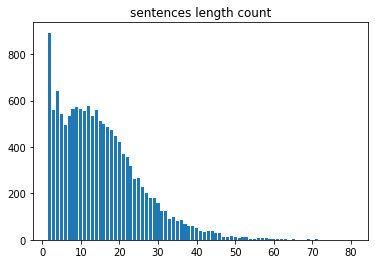

In [ ]:
len_sentences = [len(s) for s in data_hmm]
counter = Counter(len_sentences)
print(counter)

plt.title("sentences length count")
plt.bar(counter.keys(), counter.values())


In [ ]:
tagger = nltk.HiddenMarkovModelTagger.train(train_hmm)

In [ ]:
pred_hmm_tag = [tag for _,tag in tagger.tag(test_word)]

In [ ]:
accuracy_score(test_tag, pred_hmm_tag)

0.8378585174708433

In [ ]:
f1_score(test_tag, pred_hmm_tag, average="weighted")


0.8409929863525628

## CRF

In [ ]:
def features(sentence,index):
    return {
        # 'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
        'word_has_hyphen': 1 if '-' in sentence[index] else 0
    }
  
def prepareData(tagged_sentences):
    X=[]
    for sentences in tagged_sentences:
        X.append([features(sentences, index) for index in range(len(sentences))])
    return X

In [ ]:
sentences = []
tags = []
for sent in train_hmm:
    sent_word = []
    sent_tag = []
    for word, tag in sent:
        sent_word.append(word)
        sent_tag.append(tag)
    
    sentences.append(sent_word)
    tags.append(sent_tag)

In [ ]:
len(sentences)

11293

In [ ]:
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2)

In [ ]:
X_train = prepareData(train_sentences)
y_train = train_tags
X_test = prepareData(test_sentences)
y_test =  test_tags

In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

In [ ]:
y_pred=crf.predict(X_test)
y_pred_train=crf.predict(X_train)

In [ ]:
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

#F1 score test
print(metrics.flat_f1_score(y_test, y_pred,average='weighted',labels=crf.classes_))
#Accuracy score test
print(metrics.flat_accuracy_score(y_test,y_pred))

0.5604293422986507
0.5764345159877354


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
#F1 score train
print(metrics.flat_f1_score(y_train, y_pred_train,average='weighted',labels=crf.classes_))
#Accuracy score train
print(metrics.flat_accuracy_score(y_train,y_pred_train))

0.6993427288808088
0.7071855636482226


In [ ]:
labels1=crf.classes_
print(len(labels1))
labels1

29


['<s>',
 'C',
 'M',
 'N',
 'A',
 'V',
 'R',
 'E',
 '</s>',
 'P',
 'Np',
 'L',
 'Nu',
 'Nc',
 'T',
 'X',
 'Nb',
 'Ny',
 'S',
 'I',
 'Y',
 'Vy',
 'B',
 'Vb',
 'Eb',
 'Ab',
 'Mb',
 'H',
 'Ap']

In [ ]:
def crf_tagger(sent):
    sent = underthesea.word_tokenize(sent.lower())
    sent = ['<s>'] + sent + ['</s>']
    x_data = prepareData([sent])
    y_pred = crf.predict(x_data)
    return list(zip(sent, y_pred[0]))

sent = 'tôi yêu môn xử lí ngôn ngữ tự nhiên như người bạn thân'
crf_tagger(sent)

[('<s>', '<s>'),
 ('tôi', 'N'),
 ('yêu', 'V'),
 ('môn', 'N'),
 ('xử lí', 'N'),
 ('ngôn ngữ', 'N'),
 ('tự nhiên', 'A'),
 ('như', 'E'),
 ('người', 'L'),
 ('bạn', 'N'),
 ('thân', 'A'),
 ('</s>', '</s>')]

## Logistic Regression 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()

In [ ]:
Tfidf_vect = TfidfVectorizer()
wordvec = Tfidf_vect.fit_transform(all_words)

In [ ]:
wordvec.shape

(172512, 11788)

In [ ]:
len(Tfidf_vect.vocabulary_)
print(Tfidf_vect.vocabulary_)

{'gái': 3027, 'chuẩn': 1354, 'ăn': 10885, 'phân_phối': 6853, 'lá': 4613, 'xây': 10576, 'thì': 8303, 'sau': 7593, 'tin_học': 8716, 'đang': 10915, 'đầu': 11349, 'chị': 1648, 'dưới': 2582, 'xạ_thủ': 10663, 'nhưng': 6268, 'được': 11274, 'vì': 10125, 'cây': 1910, 'đã': 11120, 'bảy': 849, 'ngó': 5954, 'khi': 3905, 'cuộc_sống': 1832, 'canh': 1135, 'cô': 1955, 'tấm': 9700, 'tiễn': 8835, 'những': 6396, 'thẳm': 8522, 'hứa': 3790, 'biết': 457, 'xanh': 10437, 'bò': 700, 'quanh': 7113, 'như': 6257, 'trả': 9148, '12': 21, 'cảnh': 2144, 'lên': 4710, 'sẵn_lòng': 7880, 'trong': 8935, 'từng': 9929, 'nhà': 6150, 'bán': 596, 'quá': 7167, 'hiện': 3216, 'nhịn': 6355, 'làm': 4569, 'trẻ': 9240, 'màu': 5217, 'ăn_giá': 10889, 'túp': 9607, 'anh': 324, 'đấu_tranh': 11341, 'ra': 7305, 'nào': 6444, 'thị_xã': 8572, 'đếm': 11435, 'đẫm': 11376, 'chết': 1629, 'trúng': 9073, 'để': 11453, 'không': 4059, 'nỗi': 6651, 'nhậu': 6330, 'bốn': 1035, 'hàng': 3399, 'mình': 5291, 'nhập': 6317, 'mới': 5542, 'có': 1934, 'con_gái': 1

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(wordvec, all_tags,test_size=0.2, random_state = 5)

In [ ]:
print(Train_X.shape)
print(Test_X.shape)

(138009, 11788)
(34503, 11788)


In [ ]:
classifier_lgr = LogisticRegression()
classifier_lgr.fit(Train_X,Train_Y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictions_LGR = classifier_lgr.predict(Test_X)
accuracy_score(predictions_LGR, Test_Y)

0.7788018433179723

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(predictions_LGR, Test_Y))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        </s>       0.00      0.00      0.00         0
         <s>       1.00      0.32      0.48      6904
           A       0.65      0.91      0.76      1620
           B       0.00      0.00      0.00         0
           C       0.80      0.96      0.87      1009
           E       0.89      0.80      0.84      2518
           I       0.20      0.27      0.23        11
           L       0.96      1.00      0.98       643
           M       0.78      0.97      0.86      1031
           N       0.91      0.89      0.90      8555
          Nb       0.37      1.00      0.54        26
          Nc       0.46      0.77      0.58       516
          Np       0.59      0.93      0.72       845
          Nu       0.50      0.85      0.63        85
          Ny       0.79      0.80      0.79       155
           P       0.93      0.96      0.95      1456
           R       0.82      0.88      0.85      2363
           S       0.56    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
